In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import scale, LabelEncoder

from lightgbm import LGBMClassifier
import lightgbm as lgbm

## Processing and importing data

In [22]:
dataset = pd.read_csv("train_feat_eng.csv")

In [23]:
data = pd.get_dummies(dataset)
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('TARGET', 1), 
                                    data['TARGET'], test_size = .2, random_state=42,shuffle=True)

lgbm_train = lgbm.Dataset(X_train, y_train)

## Visualizing Parameters

In [25]:
def test_lgbm_params(name, params):

    clfs = []
    for i, param in enumerate(params):
        print("training {}/{}...".format(i+1, len(params)), end="\r", flush=True)
        parameters = {
                    name: param
        }
        clf = lgbm.train(parameters, train_set=lgbm_train)
        clfs.append(clf)

    print("predicting...", end="\r", flush=True)
    train_preds = [clf.predict(X_train) for clf in clfs]
    test_preds = [clf.predict(X_test) for clf in clfs]
    print("scoring...", end="\r", flush=True)
    train_rocs = [roc_auc_score(np.round(pred,0), y_train) for pred in train_preds]
    test_rocs = [roc_auc_score(np.round(pred,0), y_test) for pred in test_preds]
    
    print("plotting...", end="\r", flush=True)
    fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel("roc")
    ax.set_title("Roc vs {} for training and testing sets".format(name))
    ax.plot(params, train_rocs, marker='o', label="train")
    ax.plot(params, test_rocs, marker='o', label="test")
    ax.legend()
    print("", end="", flush=True)
    plt.show()


### Graphing Max Depth

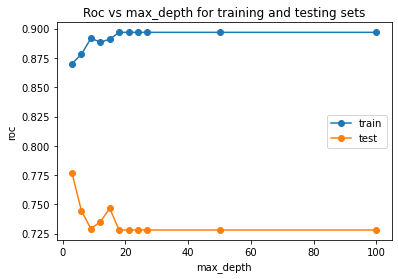

In [26]:
max_depths = [x for x in range(3,30,3)]
max_depths.append(50)
max_depths.append(100)
test_lgbm_params("max_depth", max_depths);

### Graphing Number of Leaves

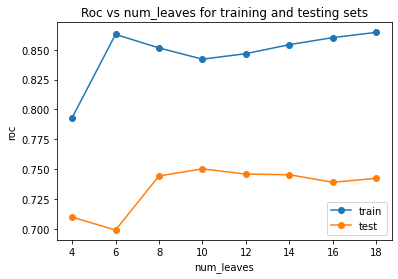

In [27]:
num_leaves = [x for x in range(4,20,2)]
test_lgbm_params("num_leaves", num_leaves);

### Min Leaf Data

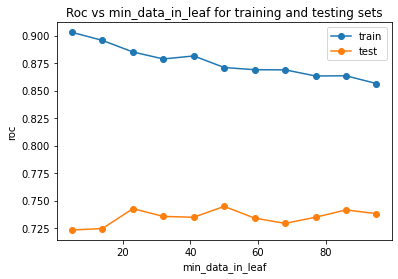

In [38]:
min_leaf_data = [x for x in range(5,100,9)]
test_lgbm_params("min_data_in_leaf", min_leaf_data);

### Boosting method

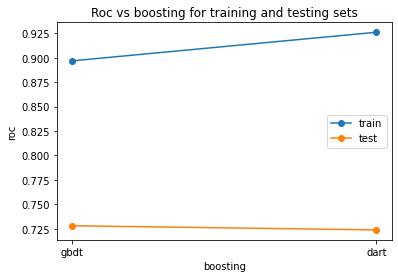

In [29]:
boost_method = ['gbdt', 'dart']
test_lgbm_params("boosting", boost_method);

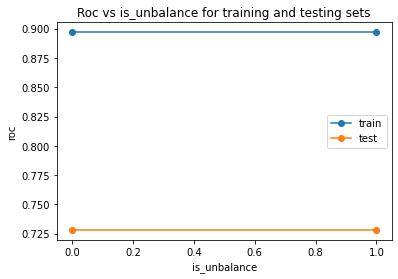

In [30]:
unbalanced = [True, False]
test_lgbm_params("is_unbalance", unbalanced);

## Creating Kaggle CSV from model

In [60]:
parameters = {
    #'num_leaves': 10,
    #'min_data_in_leaf': 50,
    'max_depth': 5
}

estimator = lgbm.train(parameters, 
                       train_set=lgbm_train)


In [61]:
#estimating probabilities
train_pred = estimator.predict(X_train)
test_pred = estimator.predict(X_test)

#converting to binary
train_pred = np.round(train_pred,0)
test_pred = np.round(test_pred,0)

print(train_pred)

[0. 0. 0. ... 0. 0. 0.]


In [62]:
print("train:")
print(accuracy_score(train_pred, y_train))
print(confusion_matrix(train_pred, y_train))
print(roc_auc_score(train_pred, y_train))
print("test:")
print(accuracy_score(test_pred, y_test))
print(confusion_matrix(test_pred, y_test))
print(roc_auc_score(test_pred, y_test))

train:
0.9202546258658255
[[226049  19535]
 [    83    341]]
0.8623500993242753
test:
0.9197925304456693
[[56517  4896]
 [   37    53]]
0.7545831772860253


In [63]:
kaggle_test = pd.read_csv("test_feat_eng.csv")
kaggle_test = pd.get_dummies(kaggle_test)

# Prevents an error on my machine
kaggle_test = kaggle_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Adding columns to match training data
kaggle_test['CODE_GENDER_XNA'] = 0
kaggle_test['NAME_FAMILY_STATUS_Unknown'] = 0
kaggle_test['NAME_INCOME_TYPE_Maternityleave'] = 0

In [64]:
#estimating probabilities
final_pred = estimator.predict(kaggle_test)
final_pred = [max(x,0) for x in final_pred]

IDs = kaggle_test[['SK_ID_CURR']].astype('int64', copy=False)

submission_lgbm = pd.DataFrame({'SK_ID_CURR': IDs.SK_ID_CURR.astype('int64', copy=False).tolist(),
'TARGET': final_pred})

submission_lgbm.to_csv("lgbm_sub.csv", index=False)